In [2]:
# Install libraries

import os
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms.v2 as v2
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from torch.utils.data import DataLoader
from typing import Tuple, Dict
from collections import defaultdict
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time


In [3]:
# Setting up train, test folders paths

train_dataset = "./Intel_Image_Classification/train_segment/originals"
test_dataset  = "./Intel_Image_Classification/test_segment"

In [4]:
# Figguring out (height, width, imager/class, format) of images from either training or testing sets

def get_info_from_data_set(path: str) -> Tuple[int, int, Dict[str, int], Dict[str, int]]:
    heights = []
    widths  = []
    formats = defaultdict()
    images_per_class = dict()

    for image_class in os.listdir(path):
        image_class_dir = os.path.join(path, image_class)
        class_images    = os.listdir(image_class_dir)

        images_per_class[image_class] = len(class_images)

        for image in class_images:
            image_path     = os.path.join(image_class_dir, image)
            image_as_array = np.array(Image.open(image_path))
            
            h, w, c = image_as_array.shape

            heights.append(h)
            widths.append(w) 

            image_name, image_extension = os.path.splitext(image_path)

            if image_extension not in formats.keys():
                formats[image_extension] = 0
            else:
                formats[image_extension] += 1
            

    average_height = sum(heights) / len(heights)
    average_wifth  = sum(widths) / len(widths)

    return (round(average_height), round(average_wifth), images_per_class, formats)

In [5]:
(average_img_h, average_img_w, images_per_class, formats) = get_info_from_data_set(train_dataset)
print(f'average_height:   {average_img_h}')
print(f'average_width:    {average_img_w}')
print(f'formats:          {formats}')
print(f'images_per_class: {images_per_class}')

average_height:   150
average_width:    150
formats:          defaultdict(None, {'.jpg': 14033})
images_per_class: {'buildings': 2191, 'forest': 2271, 'glacier': 2404, 'mountain': 2512, 'sea': 2274, 'street': 2382}


In [6]:
# Creating training, testing datasets from the local dir
# Creating an iterator over random batches (DataLoader) 

# Set of transforms to be aplied
transform = v2.Compose([
    v2.ToImage(),       
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomHorizontalFlip(p=0.5),              
    v2.Resize(size=(round(average_img_h), round(average_img_w)))  
])

# Creating train, test sets from folder in root path
train_set = torchvision.datasets.ImageFolder(root=train_dataset, transform=transform)
test_set  = torchvision.datasets.ImageFolder(root=test_dataset,  transform=transform)

# Creating iterable dataloders
train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)
test_dataloader  = DataLoader(test_set,  batch_size=32,  shuffle=True)

print(f'batches_in_train_dataloader: {len(train_dataloader)}')
print(f'batches_in_test_dataloader:  {len(test_dataloader)}')

batches_in_train_dataloader: 439
batches_in_test_dataloader:  94


In [7]:
# Getting numeric, alpabetical labels from the dataset

labels_numbers_to_strings = {val: key for key, val in train_dataloader.dataset.class_to_idx.items()}
labels_strings_to_numbers = train_dataloader.dataset.class_to_idx

print(f'labels_numbers_to_strings: {labels_numbers_to_strings}')
print(f'labels_strings_to_numbers: {labels_strings_to_numbers}')

labels_numbers_to_strings: {0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}
labels_strings_to_numbers: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


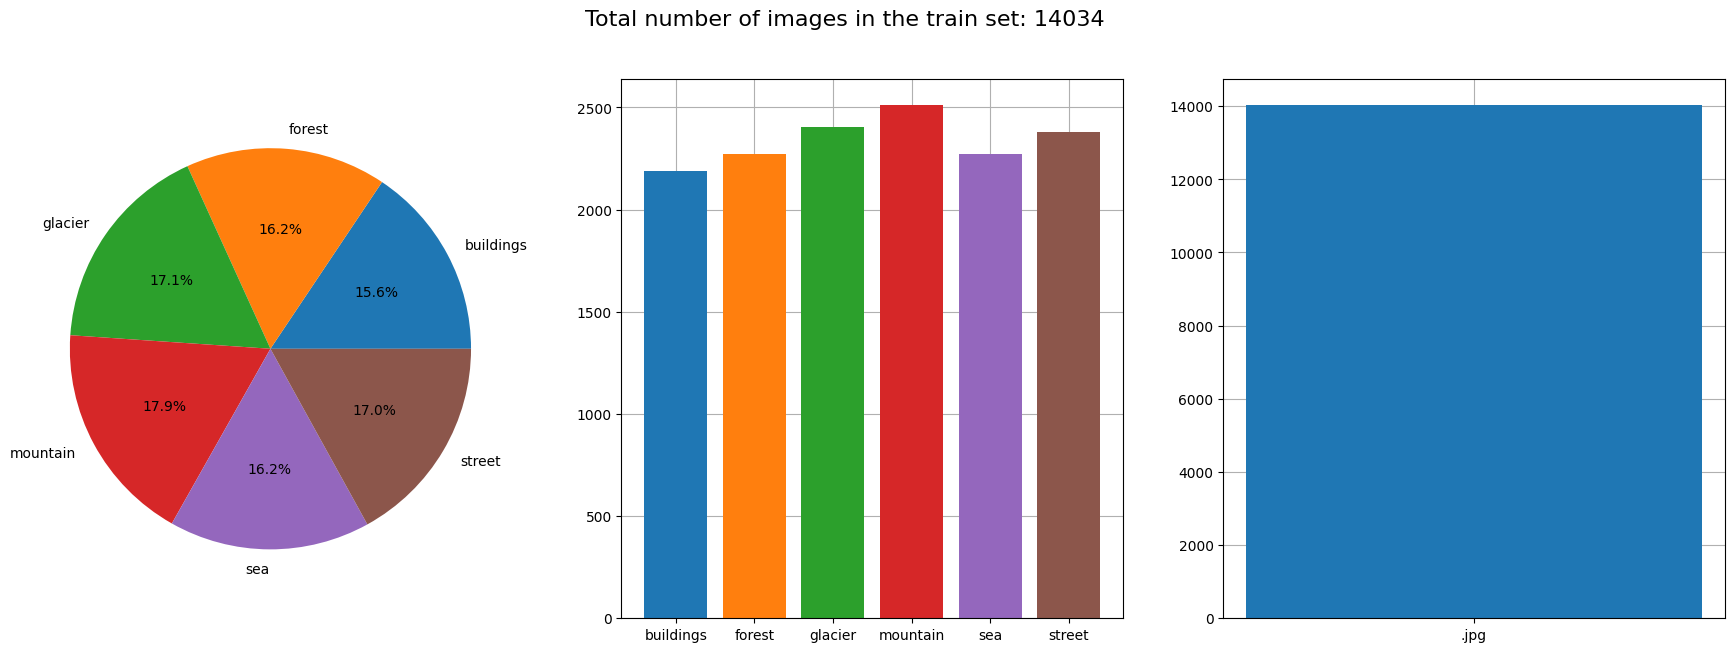

In [8]:
# Creating plots (1 row of 3 plots)
fig, ax = plt.subplots(1, 3, figsize=(22, 7))

# Creating a pie
wedges, texts, autotext = ax[0].pie(
    x      = list(images_per_class.values()), 
    labels = list(images_per_class.keys()) ,  
    autopct= lambda pct: f'{pct:.1f}%'
    ) 

# Remembering pie colors to use on the next plot
pie_colors = [wedge.get_facecolor() for wedge in wedges]

# Creating a bar plot for image/class distribution
ax[1].bar(
    images_per_class.keys(), 
    images_per_class.values(), 
    color  = pie_colors,
    zorder = 2
    )   
ax[1].grid()

# Creating a bar plot for img type distribution
ax[2].bar(
    formats.keys(), 
    formats.values(), 
    zorder = 2
    ) 
ax[2].grid()

fig.suptitle(f'Total number of images in the train set: {sum(images_per_class.values())}', fontsize=16)

plt.show()

In [9]:
# Used for displaying multiple images on a single pyplot
def print_images(images_as_vectors, labels_strings=None, labels_numeric=None):
    if labels_strings != None and labels_numeric != None:
        raise ValueError('Optional labels_strings, labels_numeric cannot both be set, use 1 of them')   
    
    if labels_strings != None:
        if len(images_as_vectors) != len(labels_strings):
            raise ValueError("Both images_as_vectors and labels_strings supposed to have the same size")

    if labels_strings != None:
        if len(images_as_vectors) != len(labels_strings):
            raise ValueError("Both images_as_vectors and labels_numeric supposed to have the same size")
    
    # Create a single plot for multiple images (one subplot per image)
    # The number of columns in the plot is determined by the number of images to display
    fig, axes = plt.subplots(ncols=len(images_as_vectors), figsize=(20, 20))

    # Setting up labels for images
    labels = [''] * len(images_as_vectors)
    if labels_strings != None:
        labels = labels_strings
    elif labels_numeric != None:
        labels = [labels_numbers_to_strings[int(i)] for i in labels_numeric]

    # Plotting images
    for index, image_as_vector in enumerate(images_as_vectors):

        # image_as_vector is expected to have shape of [chanels, h, w], since it is from datLoader
        # Pyplot expects images to have rgb chanels in the last dimention, so transpose
        image_as_vector = np.transpose(image_as_vector, (1, 2, 0))

        # If 1 image is passed, creating subplots of length 1 will create a normal subplot
        # It wont be subscriptable, so it [] is used on it, i will result in a crash
        # So need a separate if
        if len(images_as_vectors) == 1:
            fig.set_size_inches(3, 3)

            # Plotting the image
            axes.imshow(image_as_vector)
            axes.title.set_text(labels[index])
            axes.title.set_fontsize(25)

            # Removing the x and y ticks for a cleaner display
            axes.set_xticks([])
            axes.set_yticks([])
        else:
            # Plotting the image
            axes[index].imshow(image_as_vector)
            axes[index].title.set_text(labels[index])
            axes[index].title.set_fontsize(25)

            # Removing the x and y ticks for a cleaner display
            axes[index].set_xticks([])
            axes[index].set_yticks([])
    
    plt.show()

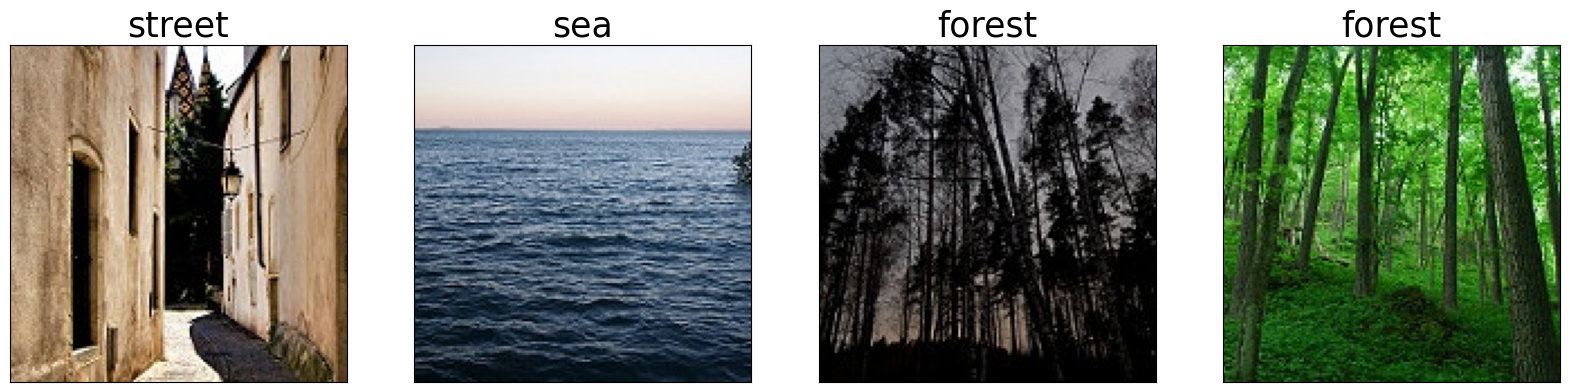

In [10]:
# Displaying some of the augmented images

first_batch = next(iter(train_dataloader))
first_batch_images         = first_batch[0]
first_batch_labels_numeric = first_batch[1]

print_images(first_batch_images[:4], labels_numeric=first_batch_labels_numeric)

In [11]:
# Registering a gpu 

print(torch.cuda.get_device_properties())

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(device)

_CudaDeviceProperties(name='NVIDIA GeForce RTX 3060 Ti', major=8, minor=6, total_memory=8191MB, multi_processor_count=38, uuid=d5fb8565-b5cf-a304-9b09-1ee3544b0753, L2_cache_size=3MB)
cuda:0


In [ ]:
class CNN_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1    = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool1    = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2    = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool2    = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3    = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool3    = nn.MaxPool2d(kernel_size=2, stride=2)

        # New ones
        self.conv4    = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool4    = nn.MaxPool2d(kernel_size=2, stride=2)

        # New ones
        # self.conv5    = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        # self.pool5    = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1      = nn.Linear(in_features=128*9*9, out_features=250)
        self.dropout1 = nn.Dropout(p=0.3)
        self.fc2      = nn.Linear(in_features=250, out_features=125)
        self.dropout2 = nn.Dropout(p=0.3)
        self.fc3      = nn.Linear(in_features=125, out_features=len(labels_numbers_to_strings))
    def forward(self, inputs):
        inputs = self.pool1(F.relu(self.conv1(inputs)))
        inputs = self.pool2(F.relu(self.conv2(inputs)))
        inputs = self.pool3(F.relu(self.conv3(inputs)))
        inputs = self.pool4(F.relu(self.conv4(inputs)))

        inputs = torch.flatten(inputs, 1) 
        inputs = F.relu(self.fc1(inputs))
        inputs = self.dropout1(inputs)
        inputs = F.relu(self.fc2(inputs))
        inputs = self.dropout2(inputs)
        inputs = self.fc3(inputs)


        return inputs

model = CNN_Model().to(device)
print(model)

CNN_Model(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=10368, out_features=250, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=250, out_features=125, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=125, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=6, bias=True)
)


In [13]:
loss_function = nn.CrossEntropyLoss()
optimizer     = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) 

In [14]:
def test_model(dataloader: DataLoader) -> Tuple[Dict[str, int], Dict[str, int]]:
    total_loss      = 0
    total_accuracy  = 0
    total_precision = 0
    total_recall    = 0
    total_f1        = 0

    for inputs, labels in dataloader:

        # Moving tensors onto a gpu
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Getiing a prediction
        batch_predictions = model(inputs)

        loss = loss_function(batch_predictions, labels)
        total_loss += loss.item()

        # Getting a predicted class for each input
        max_values, max_indices = torch.max(batch_predictions, 1)

        total_accuracy  += np.average(accuracy_score(labels.cpu(), max_indices.cpu()))
        total_precision += np.average(precision_score(labels.cpu(), max_indices.cpu(), average=None, zero_division=0))
        total_recall    += np.average(recall_score(labels.cpu(), max_indices.cpu(), average=None, zero_division=0))
        total_f1        += np.average(f1_score(labels.cpu(), max_indices.cpu(), average=None, zero_division=0))
    
    total_loss      /= len(dataloader)   
    total_accuracy  /= len(dataloader)
    total_precision /= len(dataloader)
    total_recall    /= len(dataloader)
    total_f1        /= len(dataloader)

    return (total_loss, total_accuracy, total_precision, total_recall, total_f1)

In [15]:
import torch.optim
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)

# TODO: try exponential lr next
# TODO: try AdamGrad

In [16]:
# optimizer.param_groups[0]['lr']

In [18]:
# Training the model

n_epochs = 33

# Using these for logging
epoch_losses             = []
epoch_accuracy           = []
epoch_precision          = []
epoch_recall             = []  
epoch_f1                 = []

epoch_losses_on_test     = []
epoch_accuracy_on_test   = []
epoch_precisions_on_test = []
epoch_recalls_on_test    = []
epoch_f1_on_test         = []

counter_for_lr_reduction = 0
min_test_loss            = float('inf')
best_weights             = 0

epoch_start_time         = 0     
model_training_time      = 0    

# TODO: amke this look good again
print("[{:^10}    {:^12} {:^10} {:^10} {:^10} {:^10}      {:^10} {:^12} {:^12} {:^12} {:^10}      {:^12} {:^12}]".format(
        "Epoch",    "Batch_Loss", "Accuracy", "Recall", "Precision", "F1",    "Test_Loss", "Test_Accuracy", "Test_Recall", "Test_Precision", "Test_F1",    "Batch_Time", "Total_Time"))

for epoch in range(n_epochs):
    epoch_start_time = time.time()
    
    # These to track performance during each epoch
    loss      = 0.0
    accuracy  = 0.0
    precision = 0.0
    recall    = 0.0
    f1        = 0.0

    for inputs, labels in train_dataloader:
        # Moving tensors onto a gpu
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients (Reson for it: https://medium.com/@lazyprogrammerofficial/in-pytorch-why-do-we-need-to-call-optimizer-zero-grad-8e19fdc1ad2f#:~:text=zero_grad()%20method%20is%20used,respect%20to%20the%20model%20parameters.)
        optimizer.zero_grad()

        # Outputs -> Tensor.shape = (batch_size, number_of_possible_classes)
        outputs = model(inputs)

        # Loss, Backpropogation, Optimization
        cur_loss = loss_function(outputs, labels)
        cur_loss.backward()
        optimizer.step()

        # Storing stuff for plotting
        loss += cur_loss.item()
        
        # Getting labels for predicted ouputs
        max_values, max_indices = torch.max(outputs, 1)

        accuracy  += np.average(accuracy_score(labels.cpu(), max_indices.cpu()))
        precision += np.average(precision_score(labels.cpu(), max_indices.cpu(), average=None, zero_division=0))
        recall    += np.average(recall_score(labels.cpu(), max_indices.cpu(), average=None, zero_division=0))
        f1        += np.average(f1_score(labels.cpu(), max_indices.cpu(), average=None, zero_division=0))

    # Averaging oven number of batches in epoch
    loss      /= len(train_dataloader)
    accuracy  /= len(train_dataloader)
    precision /= len(train_dataloader)
    recall    /= len(train_dataloader)
    f1        /= len(train_dataloader)

    # Storing last epoch's results
    epoch_losses.append(loss)
    epoch_accuracy.append(accuracy)
    epoch_precision.append(precision)
    epoch_recall.append(recall)
    epoch_f1.append(f1)

    # Testing current state of the model based on testing data
    (test_loss, test_accuracy, test_precision, test_recall, test_f1) = test_model(test_dataloader)
    epoch_losses_on_test.append(test_loss)
    epoch_accuracy_on_test.append(test_accuracy)
    epoch_precisions_on_test.append(test_precision)
    epoch_recalls_on_test.append(test_recall)
    epoch_f1_on_test.append(test_f1)

    # Storing the best model state bassed on testing loss
    if test_loss < min_test_loss:
        min_test_loss = test_loss
        best_weights = model.state_dict()

    # scheduler.step()

    # if epoch >= 13:
    #     scheduler.step() 

    # if epoch == 3:
    #     optimizer.param_groups[0]['lr'] /= 10


    if epoch == 10:
        optimizer.param_groups[0]['lr'] /= 10




    # Trying to stop overfitting 
    # if(epoch > 5 and test_loss > min_test_loss):
    #     for group in optimizer.param_groups:
    #         group['lr'] /= 10
    #         counter_for_lr_reduction += 1
    
    # Logging time spent on the previous epoch
    epoch_time_spent_min = (time.time() - epoch_start_time) / 60
    model_training_time  += epoch_time_spent_min

    print("[{:^10}    {:^10.4f} {:^10.4f} {:^10.4f} {:^10.4f} {:^10.4f}      {:^10.4f} {:^10.4f} {:^15.4f} {:^15.4f} {:^10.4f}      {:^12} {:^12} ]".format(
        f"{epoch + 1}/{n_epochs}", loss, accuracy, recall, precision, f1, test_loss, test_accuracy, test_recall, test_precision, test_f1,
        f"{epoch_time_spent_min:.1f} min", f"{model_training_time:.1f} min"))

    # Not wasting time on useless epochs
    # if counter_for_lr_reduction == 5:
    #     n_epochs = epoch + 1
    #     break

print('Done Training')    

# Loading the best recorded state
model.load_state_dict(best_weights)


[  Epoch        Batch_Loss   Accuracy    Recall   Precision      F1          Test_Loss  Test_Accuracy Test_Recall  Test_Precision  Test_F1         Batch_Time   Total_Time ]
[   1/33         0.3594     0.8751     0.8767     0.8767     0.8641          0.4676     0.8418       0.8456          0.8440        0.8304          0.3 min      0.3 min    ]
[   2/33         0.3602     0.8770     0.8774     0.8758     0.8643          0.4544     0.8501       0.8553          0.8551        0.8427          0.3 min      0.5 min    ]
[   3/33         0.3576     0.8770     0.8766     0.8765     0.8651          0.4591     0.8429       0.8435          0.8388        0.8280          0.3 min      0.8 min    ]
[   4/33         0.3572     0.8766     0.8736     0.8757     0.8618          0.4581     0.8459       0.8483          0.8445        0.8306          0.3 min      1.1 min    ]
[   5/33         0.3596     0.8755     0.8733     0.8741     0.8621          0.4497     0.8465       0.8491          0.8496        0.83

<All keys matched successfully>

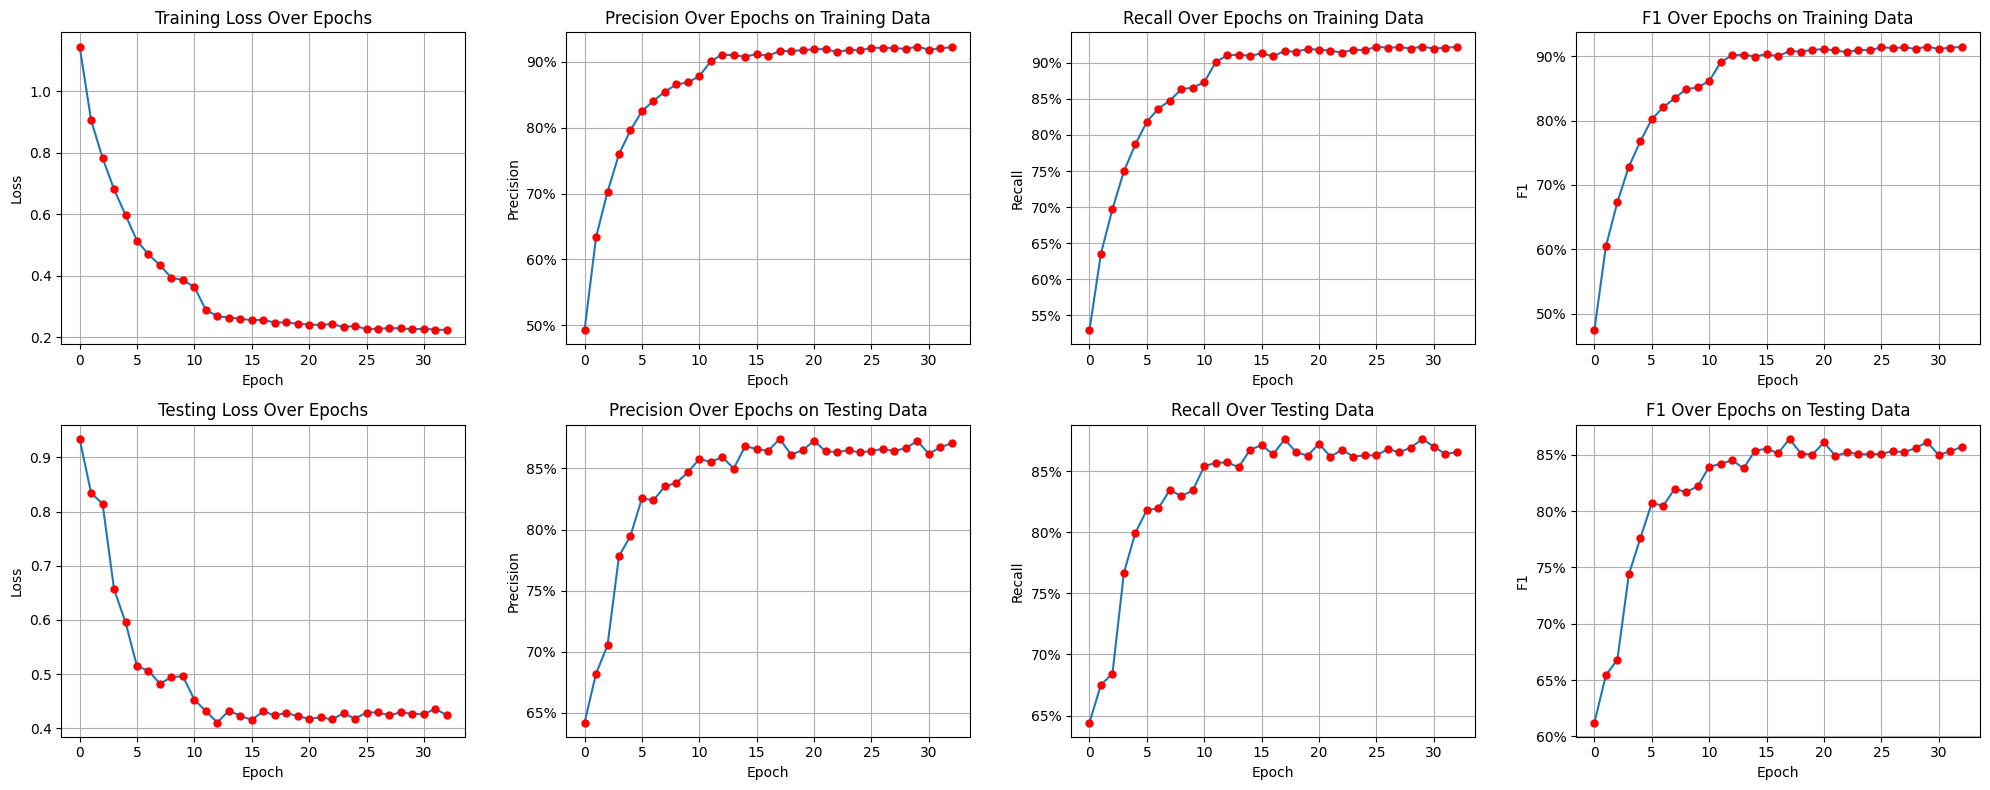

In [54]:
# Creating 8 subplots (2 rows of 4)
fig, ax = plt.subplots(2, 4, figsize=(20, 8)) 

# Plotting the first graph (Training Loss)
ax[0][0].plot(range(n_epochs), epoch_losses, marker='o',  markerfacecolor='red', markeredgecolor='None')
ax[0][0].set_title("Training Loss Over Epochs")
ax[0][0].set_xlabel("Epoch")
ax[0][0].set_ylabel("Loss")
ax[0][0].grid()

# Plotting the second graph (Training Preciison)
ax[0][1].plot(range(n_epochs), epoch_precision, marker='o',  markerfacecolor='red', markeredgecolor='None')
ax[0][1].set_title("Precision Over Epochs on Training Data")
ax[0][1].set_xlabel("Epoch")
ax[0][1].set_ylabel("Precision")
ax[0][1].yaxis.set_major_formatter(lambda y, pos: f'{int(y * 100)}%')
ax[0][1].grid()

# Protting the third graph (Training Recall)
ax[0][2].plot(range(n_epochs), epoch_recall, marker='o',  markerfacecolor='red', markeredgecolor='None')
ax[0][2].set_title("Recall Over Epochs on Training Data")
ax[0][2].set_xlabel("Epoch")
ax[0][2].set_ylabel("Recall")
ax[0][2].yaxis.set_major_formatter(lambda y, pos: f'{int(y * 100)}%')
ax[0][2].grid()

# Protting the fourth graph (Training F1)
ax[0][3].plot(range(n_epochs), epoch_f1, marker='o',  markerfacecolor='red', markeredgecolor='None')
ax[0][3].set_title("F1 Over Epochs on Training Data")
ax[0][3].set_xlabel("Epoch")
ax[0][3].set_ylabel("F1")
ax[0][3].yaxis.set_major_formatter(lambda y, pos: f'{int(y * 100)}%')
ax[0][3].grid()

# ==============================================================================================================

# Plotting the first graph (Testing Loss)
ax[1][0].plot(range(n_epochs), epoch_losses_on_test, marker='o',  markerfacecolor='red', markeredgecolor='None')
ax[1][0].set_title("Testing Loss Over Epochs")
ax[1][0].set_xlabel("Epoch")
ax[1][0].set_ylabel("Loss")
ax[1][0].grid()

# Plotting the second graph (Training Preciison)
ax[1][1].plot(range(n_epochs), epoch_precisions_on_test, marker='o',  markerfacecolor='red', markeredgecolor='None')
ax[1][1].set_title("Precision Over Epochs on Testing Data")
ax[1][1].set_xlabel("Epoch")
ax[1][1].set_ylabel("Precision")
ax[1][1].yaxis.set_major_formatter(lambda y, pos: f'{int(y * 100)}%')
ax[1][1].grid()

# Protting the third graph (Testing Recall)
ax[1][2].plot(range(n_epochs), epoch_recalls_on_test, marker='o',  markerfacecolor='red', markeredgecolor='None')
ax[1][2].set_title("Recall Over Testing Data")
ax[1][2].set_xlabel("Epoch")
ax[1][2].set_ylabel("Recall")
ax[1][2].yaxis.set_major_formatter(lambda y, pos: f'{int(y * 100)}%')
ax[1][2].grid()

# Protting the fourth graph (Testing F1)
ax[1][3].plot(range(n_epochs), epoch_f1_on_test, marker='o',  markerfacecolor='red', markeredgecolor='None')
ax[1][3].set_title("F1 Over Epochs on Testing Data")
ax[1][3].set_xlabel("Epoch")
ax[1][3].set_ylabel("F1")
ax[1][3].yaxis.set_major_formatter(lambda y, pos: f'{int(y * 100)}%')
ax[1][3].grid()

# Adjusting layout to avoid overlap
plt.tight_layout()
plt.subplots_adjust(wspace=0.25)
plt.show()

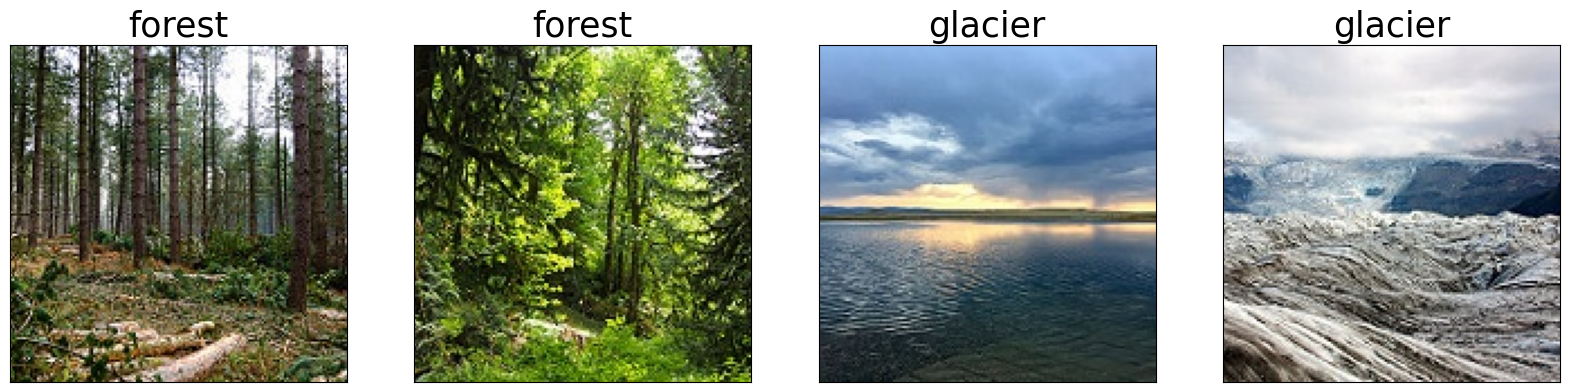

In [ ]:
# Visualising a couple of images from the testing set

testing_batch = next(iter(test_dataloader))

testing_batch_images = testing_batch[0]
testing_batch_labels = testing_batch[1]

print_images(testing_batch_images[:4], labels_numeric=testing_batch_labels[:4])

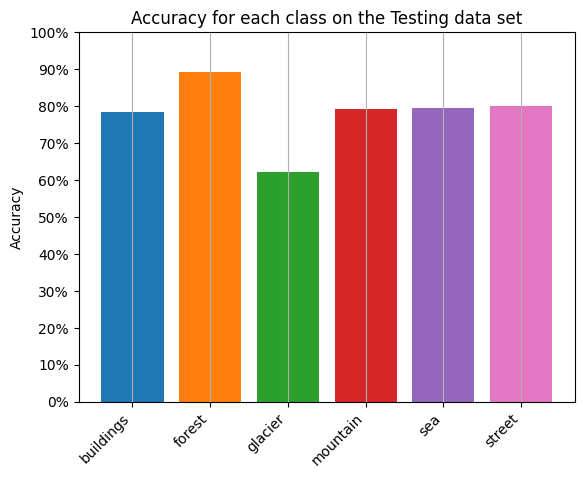

In [ ]:
# TODO: Need this to work again

# fig, ax = plt.subplots()
# classes   = labels_strings_to_numbers.keys()

# # Calculating accuracy for each class
# each_class_accuracy = []
# for i in range(len(classes)):
#     class_i_accuracy = (each_class_correct_predictions[i] / each_class_occurance[i])
#     each_class_accuracy.append(class_i_accuracy)

# colors = [
#     "#1f77b4",  # Blue
#     "#ff7f0e",  # Orange
#     "#2ca02c",  # Green
#     "#d62728",  # Red
#     "#9467bd",  # Purple
#     "#e377c2",  # Pink   
# ]

# # Plotting
# ax.bar(classes, each_class_accuracy, color=colors)
# ax.set_ylabel('Accuracy')
# ax.set_title(f'Accuracy for each class on the {"Testing data set"}')
# ax.set_ylim(0, 1)
# ax.set_yticks(np.arange(0, 1.1, 0.1))
# ax.yaxis.set_major_formatter(lambda x, pos: f'{int(x * 100)}%')
# ax.grid(axis='x')

# plt.xticks(rotation=45, ha='right')
# plt.show()

# NOTE: the above image is not representative of the current model 

In [ ]:
# Manually testing on a random pictures from the training set

def test_on_a_random_picture(model: CNN_Model, dataloader: DataLoader, n = 10):
    # Getting a random image
    first_batch      = next(iter(dataloader))
    images           = []
    golden_labels    = []
    predicted_labels = []

    # Getting images
    for i in range(n):
        images.append(first_batch[0][i])

    # Getting labels
    for i in range(n):
        numeric_golden_label = first_batch[1][i].item()
        string_golden_label  = labels_numbers_to_strings[numeric_golden_label]
        golden_labels.append(string_golden_label)

        prediction_vector = model(images[i].unsqueeze(0).to(device))
        prediction_max_value, prediction_index = torch.max(prediction_vector, 1)
        predicted_class   = labels_numbers_to_strings[prediction_index.item()]
        predicted_labels.append(predicted_class)
    
    for i in range(n):
        print(f'Actual class:    {golden_labels[i]}')
        print(f'Predicted class: {predicted_labels[i]}')
        print_images([images[i]], [predicted_labels[i]])

Actual class:    buildings
Predicted class: street


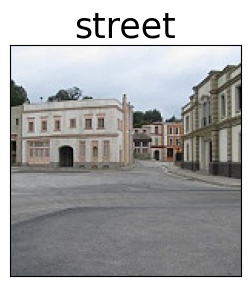

Actual class:    buildings
Predicted class: buildings


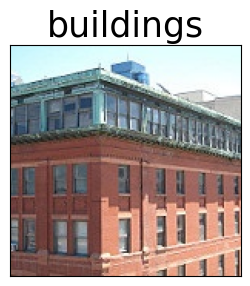

Actual class:    buildings
Predicted class: buildings


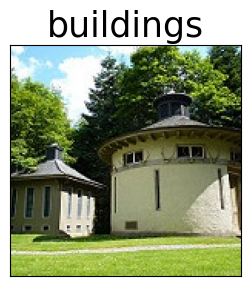

Actual class:    forest
Predicted class: buildings


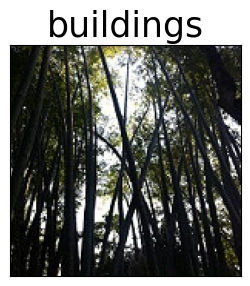

Actual class:    glacier
Predicted class: glacier


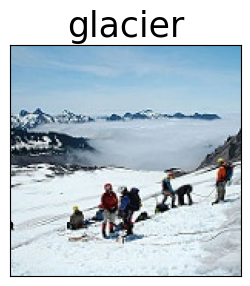

Actual class:    glacier
Predicted class: glacier


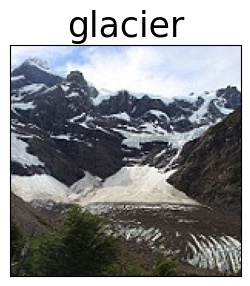

Actual class:    mountain
Predicted class: mountain


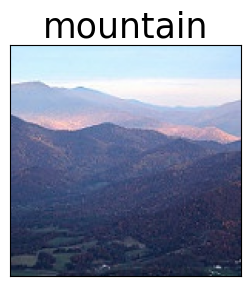

Actual class:    sea
Predicted class: sea


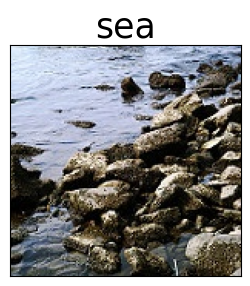

Actual class:    buildings
Predicted class: buildings


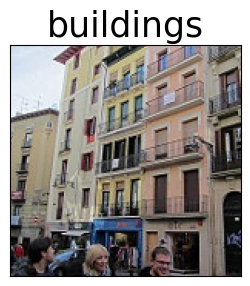

Actual class:    forest
Predicted class: forest


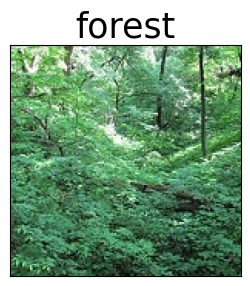

In [ ]:
test_on_a_random_picture(model, test_dataloader)

In [ ]:
# TODO: maybe add recall, dont know if i need to, seems like accurasy is the most important thing for this type of classification

In [ ]:
torch.save(model, 'model.pth')

In [ ]:
model = torch.load('model.pth', weights_only=False)

In [ ]:
model

CNN_Model(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=18496, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=6, bias=True)
)

In [ ]:
from torchvision import models
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(labels_numbers_to_strings))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Admin/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:48<00:00, 2.11MB/s]


In [ ]:
# ============================================================================================================================================== #
#                                                   Model Optimisation Testing Is Done Below                                                     #
# ============================================================================================================================================== #


In [ ]:
import skorch
from sklearn.model_selection import GridSearchCV

In [ ]:
class Test_CNN_Model(nn.Module):
    def __init__(self, activation=F.relu, fc1_p=0.5):
        super().__init__()

        self.activation = activation

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(in_features=64 * 18 * 18, out_features=500)
        self.dropout1 = nn.Dropout(p=fc1_p)

        self.fc2 = nn.Linear(in_features=500, out_features=50)
        self.dropout2 = nn.Dropout(p=fc1_p)

        self.fc3 = nn.Linear(in_features=50, out_features=len(labels_numbers_to_strings))

    def forward(self, inputs):
        inputs = self.conv1(inputs)
        inputs = self.pool1(self.activation(inputs))

        inputs = self.conv2(inputs)
        inputs = self.pool2(self.activation(inputs))

        inputs = self.conv3(inputs)
        inputs = self.pool3(self.activation(inputs))

        inputs = torch.flatten(inputs, 1)

        inputs = self.activation(self.fc1(inputs))
        inputs = self.dropout1(inputs)

        inputs = self.activation(self.fc2(inputs))
        inputs = self.dropout2(inputs)

        inputs = self.fc3(inputs)

        return inputs


In [ ]:
test = skorch.NeuralNetClassifier(
    Test_CNN_Model,
    criterion=nn.CrossEntropyLoss,
    optimizer=optim.Adam,
    verbose=False
)

grid_dataloader = DataLoader(train_set, batch_size=64, shuffle=True)

first_bacth = next(iter(grid_dataloader))
images      = first_bacth[0]
labels      = first_bacth[1]

param_grid = {
    'max_epochs':              [25],
    'optimizer__lr':           [0.001, 0.0001, 0.00005],                             
    'optimizer__weight_decay': [1e-4, 1e-5, 1e-6],                  
    'module__fc1_p':           [0.3, 0.5],                         
    'module__activation':      [F.relu, F.leaky_relu],                               
}

grid = GridSearchCV(estimator=test, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(images, labels)

In [ ]:
print(f'Best: {grid_result.best_score_} using {grid_result.best_params_}\n\n')
means  = grid_result.cv_results_['mean_test_score']
stds   = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    # TODO: make pretty print here like in training logging
    # TODO: also decimals are to long, trucate, leave about 3,4 decimals
    print(f'{mean} ({stdev}) with: {param}')

Best: 0.5007215007215007 using {'max_epochs': 25, 'module__activation': <function relu at 0x0000020DA34C4860>, 'module__fc1_p': 0.3, 'optimizer__lr': 0.001, 'optimizer__weight_decay': 1e-05}


0.37445887445887444 (0.06325384933420979) with: {'max_epochs': 25, 'module__activation': <function relu at 0x0000020DA34C4860>, 'module__fc1_p': 0.3, 'optimizer__lr': 0.001, 'optimizer__weight_decay': 0.0001}
0.5007215007215007 (0.05077232925183024) with: {'max_epochs': 25, 'module__activation': <function relu at 0x0000020DA34C4860>, 'module__fc1_p': 0.3, 'optimizer__lr': 0.001, 'optimizer__weight_decay': 1e-05}
0.4083694083694083 (0.10349449395117524) with: {'max_epochs': 25, 'module__activation': <function relu at 0x0000020DA34C4860>, 'module__fc1_p': 0.3, 'optimizer__lr': 0.001, 'optimizer__weight_decay': 1e-06}
0.2662337662337662 (0.04765183182094767) with: {'max_epochs': 25, 'module__activation': <function relu at 0x0000020DA34C4860>, 'module__fc1_p': 0.3, 'optimizer__lr': 0.0001, 'optimizer